Base directory: results/gib_multirun_bug2
Algorithms to analyze: ['nsga2_comb1', 'nsga2_comb2', 'nsga2_comb3', 'nsga2_comb4', 'nsga2_rl']
Using scorer: distance
Convergence mode: select_run
Selected run index: 5

Searching for: results/gib_multirun_bug2/nsga2_comb1_run*
  ✓ Found run 8: score=114814.53
  ✓ Found run 2: score=112619.29
  ✓ Found run 3: score=116471.70
  ✓ Found run 1: score=114742.08
  ✓ Found run 7: score=117484.37
  ✓ Found run 4: score=108423.02
  ✓ Found run 6: score=113949.75
  ✓ Found run 9: score=107842.92
  ✓ Found run 5: score=110669.14
  ✓ Found run 10: score=111755.87

Searching for: results/gib_multirun_bug2/nsga2_comb2_run*
  ✓ Found run 2: score=112619.29
  ✓ Found run 1: score=115836.53
  ✓ Found run 6: score=114599.50
  ✓ Found run 10: score=112004.07
  ✓ Found run 5: score=110824.92
  ✓ Found run 9: score=107955.01
  ✓ Found run 7: score=118053.59
  ✓ Found run 4: score=108446.98
  ✓ Found run 3: score=116492.35
  ✓ Found run 8: score=114963.18

Searchi

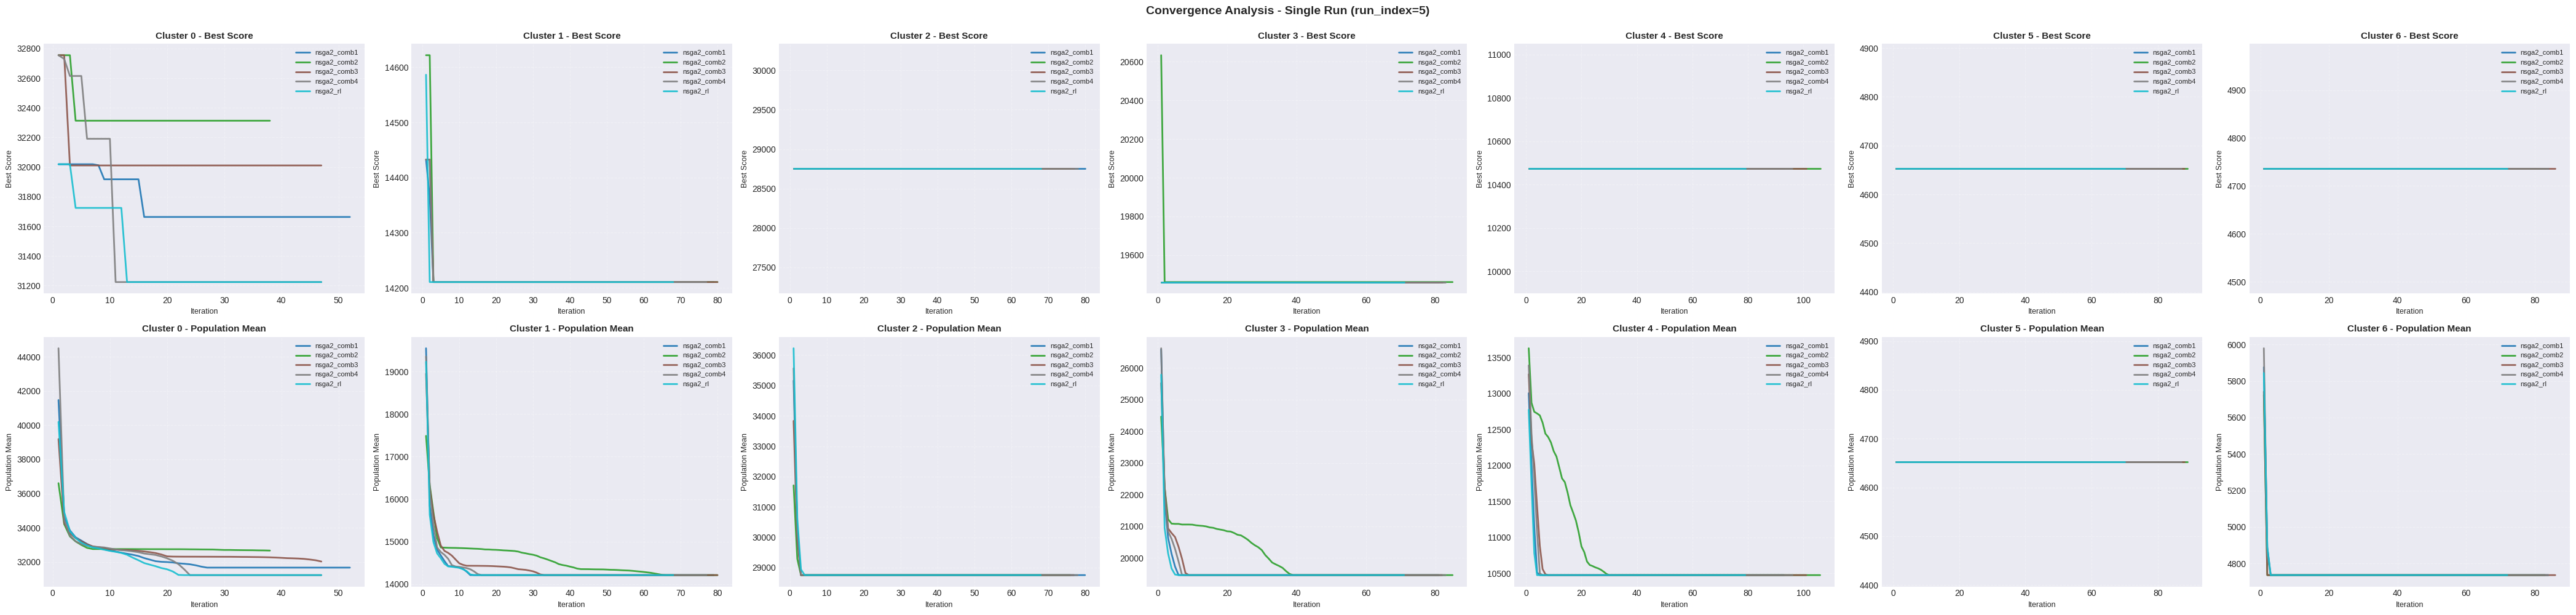

Statistics Summary
config_name          mean         std  count           min           max
nsga2_comb1 112877.266395 3230.255372     10 107842.916681 117484.365378
nsga2_comb2 113179.542173 3398.055793     10 107955.011194 118053.591687
nsga2_comb3 112847.335974 3179.081429     10 107842.916681 117679.069635
nsga2_comb4 112847.224144 3273.401087     10 107842.916681 117558.161149
   nsga2_rl 112829.429807 3165.349733     10 107842.916681 116943.332227

✓ Saved: multirun_statistics.csv
✓ Saved: multirun_detailed.csv
✓ Saved: multirun_convergence_by_cluster.csv

Convergence Speed Analysis Per Cluster (Iterations to 95%)
 cluster_idx config_name   final_best  convergence_iter  total_iters
           0 nsga2_comb1 31663.142667               1.0           52
           0 nsga2_comb2 32312.898206               1.0           38
           0 nsga2_comb3 32010.956952               1.0           47
           0 nsga2_comb4 31223.729413               1.0           47
           0    nsga2_rl 312

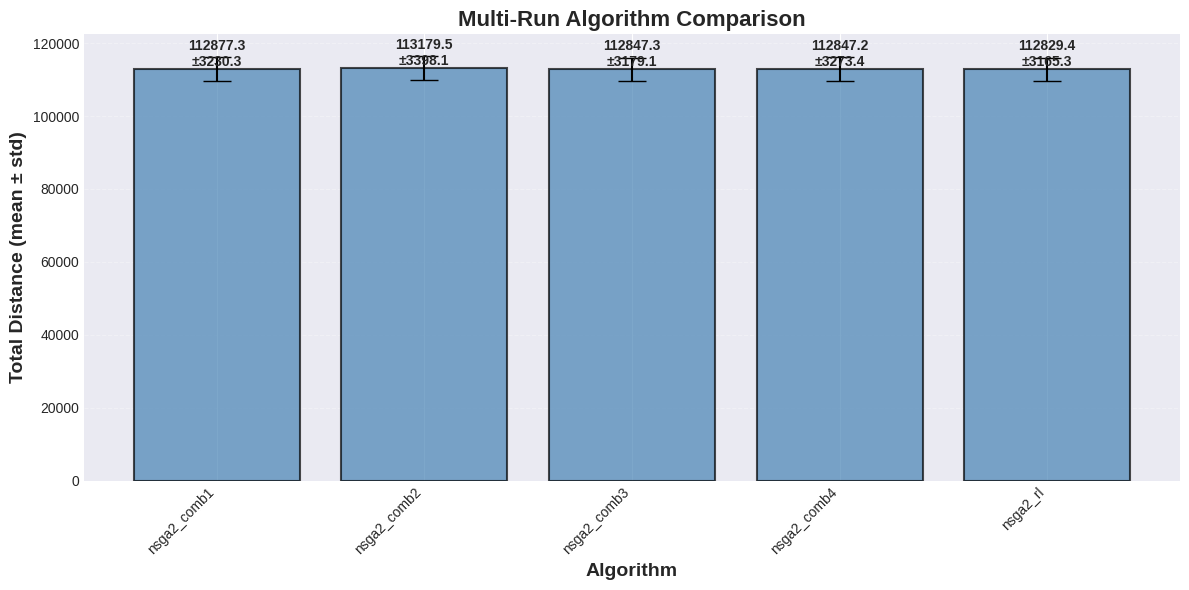

✓ Boxplot saved to: multirun_boxplot.png


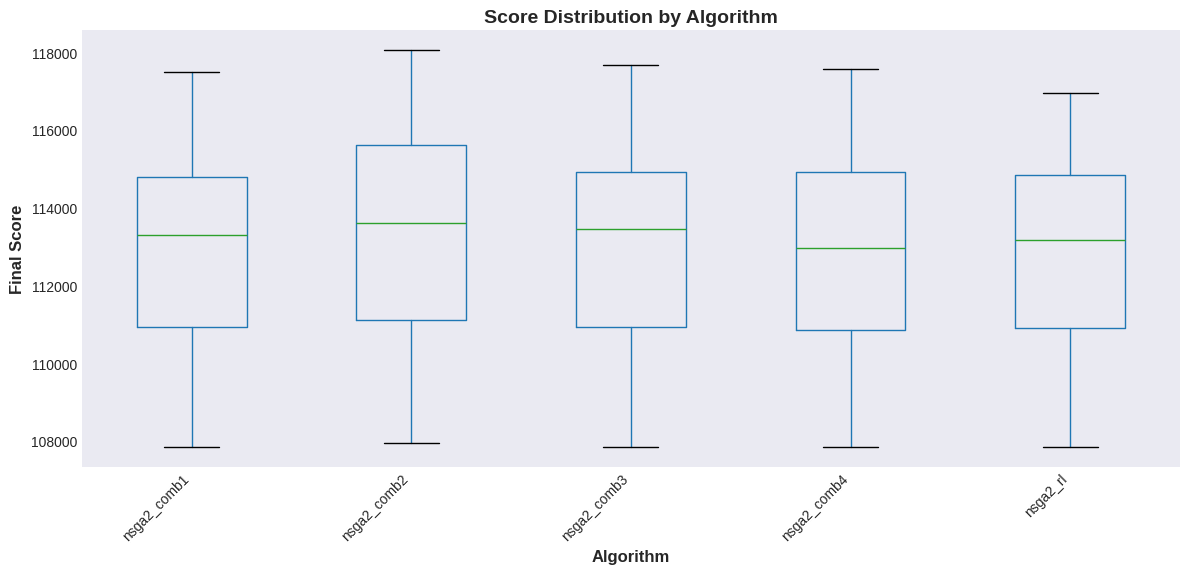

Analysis Complete!
Total runs analyzed: 50
Algorithms compared: 5
Clusters analyzed: 7

Output files:
  - multirun_statistics.csv
  - multirun_detailed.csv
  - multirun_convergence_by_cluster.csv
  - multirun_convergence_speed.csv
  - multirun_analysis.png
  - multirun_boxplot.png
  - convergence_by_cluster.png


In [ ]:
# Cell 1: Imports
import json
from pathlib import Path
from typing import Dict, List, Any, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Enable inline plotting
%matplotlib inline

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# ============================================================

# Cell 2: Configuration
RESULTS_BASE_DIR = Path("results/gib_multirun_bug2")  # Base directory for multirun results
ALGOS = ["nsga2_comb1", "nsga2_comb2", "nsga2_comb3", "nsga2_comb4", "nsga2_rl"]  # Must match dir prefix: nsga2_rl_run1, nsga2_rl_run2, ...
SCORER = "distance"  # "distance" or "cost"

# Convergence plot options
CONVERGENCE_MODE = "select_run"  # "average_runs" or "select_run"
SELECTED_RUN_INDEX = 6  # Which run to visualize (0-indexed). Only used if CONVERGENCE_MODE="select_run"

print(f"Base directory: {RESULTS_BASE_DIR}")
print(f"Algorithms to analyze: {ALGOS}")
print(f"Using scorer: {SCORER}")
print(f"Convergence mode: {CONVERGENCE_MODE}")
if CONVERGENCE_MODE == "select_run":
    print(f"Selected run index: {SELECTED_RUN_INDEX}")

# ============================================================

# Cell 3: Collect All Runs
def collect_all_runs(base_dir: Path, algos: List[str]) -> pd.DataFrame:
    """
    Collect all run_summary_aggregated.json files from multirun directories.
    Returns DataFrame with columns: algorithm, run_index, final_score, output_dir
    """
    data = []
    
    # For each algorithm, find all run directories INSIDE base_dir
    for algo in algos:
        pattern = f"{algo}_run*"
        print(f"\nSearching for: {base_dir / pattern}")
        
        for run_dir in base_dir.glob(pattern):
            if not run_dir.is_dir():
                continue
            
            summary_file = run_dir / "run_summary_aggregated.json"
            if not summary_file.exists():
                print(f"  Warning: {summary_file} not found, skipping")
                continue
            
            with open(summary_file, "r") as f:
                summary = json.load(f)
            
            algorithm = summary.get("algorithm", algo)
            run_index = summary.get("run_index", 0)
            
            # Get the appropriate score based on scorer
            scorer = summary.get("scorer", SCORER)
            if scorer == "distance":
                final_score = summary.get("sum_final_distance", 0.0)
            elif scorer == "cost":
                final_score = summary.get("sum_final_cost", 0.0)
            else:
                final_score = summary.get("sum_final_distance", 0.0)
            
            data.append({
                "algorithm": algorithm,
                "config_name": summary.get("config_name", algorithm),
                "run_index": run_index,
                "final_score": final_score,
                "output_dir": str(run_dir),
                "clusters": summary.get("clusters", 0),
            })
            print(f"  ✓ Found run {run_index + 1}: score={final_score:.2f}")
    
    df = pd.DataFrame(data)
    print(f"\n{'='*60}")
    print(f"✓ Collected {len(df)} runs total")
    return df

# Collect data
df = collect_all_runs(RESULTS_BASE_DIR, ALGOS)

if df.empty:
    print("❌ No data found! Check RESULTS_BASE_DIR and ALGOS.")
else:
    print(f"\n✓ Found algorithms: {df['config_name'].unique().tolist()}")
    print(f"✓ Runs per algorithm:")
    print(df.groupby('config_name').size())

# ============================================================

# ============================================================
# Cell 4: Load Convergence Data Per Cluster
def load_convergence_by_cluster(df: pd.DataFrame) -> Dict[str, Dict[int, List[Tuple[int, pd.DataFrame]]]]:
    """
    Load metrics CSV files organized by algorithm and cluster index.
    Returns: {config_name: {cluster_idx: [(run_index, dataframe), ...]}}
    """
    convergence_data = defaultdict(lambda: defaultdict(list))
    
    for _, row in df.iterrows():
        config_name = row['config_name']
        run_index = row['run_index']
        output_dir = Path(row['output_dir'])
        
        # Find all cluster directories
        cluster_dirs = sorted(output_dir.glob("cluster_*"))
        
        for cluster_dir in cluster_dirs:
            # Extract cluster index from directory name
            cluster_idx = int(cluster_dir.name.split('_')[1])
            
            # Look for metrics files
            metrics_files = list(cluster_dir.glob("metrics_*.csv"))
            
            if metrics_files:
                metrics_file = metrics_files[0]
                try:
                    metrics_df = pd.read_csv(metrics_file)

                    # --- FIX: RL iter starts at 0, shift to 1-based here ---
                    # Assuming RL config names contain "rl" (e.g. "nsga2_rl")
                    if 'iter' in metrics_df.columns and 'rl' in str(config_name).lower():
                        metrics_df['iter'] = metrics_df['iter'] + 1
                    # ------------------------------------------------------

                    convergence_data[config_name][cluster_idx].append((run_index, metrics_df))
                except Exception as e:
                    print(f"  Warning: Could not read {metrics_file}: {e}")
    
    print(f"\n{'='*60}")
    print("Convergence Data Loaded by Cluster")
    print(f"{'='*60}")
    for config_name, clusters in convergence_data.items():
        print(f"{config_name}:")
        for cluster_idx, run_data in sorted(clusters.items()):
            run_indices = [run_idx for run_idx, _ in run_data]
            print(f"  Cluster {cluster_idx}: {len(run_data)} runs (indices: {run_indices})")
    
    return dict(convergence_data)

convergence_by_cluster = load_convergence_by_cluster(df)


# ============================================================

# Cell 5: Aggregate Convergence Per Cluster
def aggregate_cluster_convergence(convergence_by_cluster: Dict, mode: str = "average_runs", 
                                  selected_run_index: int = 0) -> pd.DataFrame:
    """
    Aggregate convergence curves per cluster.
    
    Args:
        mode: "average_runs" or "select_run"
        selected_run_index: Which run to use if mode="select_run"
    
    Returns DataFrame with: config_name, cluster_idx, iter, best_mean, best_std, mean_mean, mean_std
    """
    aggregated = []
    
    if mode == "select_run":
        print(f"\n{'='*60}")
        print(f"Using SINGLE RUN mode: run_index={selected_run_index}")
        print(f"{'='*60}")
        
        for config_name, clusters in convergence_by_cluster.items():
            for cluster_idx, run_data in clusters.items():
                # Find the specific run
                matching_runs = [df for run_idx, df in run_data if run_idx == selected_run_index]
                
                if not matching_runs:
                    print(f"  Warning: {config_name} cluster {cluster_idx} - no data for run {selected_run_index}")
                    continue
                
                cluster_df = matching_runs[0]
                
                if 'best' not in cluster_df.columns or 'mean' not in cluster_df.columns:
                    continue
                
                # No averaging - just use the single run data
                for i, row in cluster_df.iterrows():
                    aggregated.append({
                        'config_name': config_name,
                        'cluster_idx': cluster_idx,
                        'iter': row['iter'],
                        'best_mean': row['best'],
                        'best_std': 0.0,  # No std for single run
                        'mean_mean': row['mean'],
                        'mean_std': 0.0,  # No std for single run
                        'n_runs': 1
                    })
    
    else:  # average_runs
        print(f"\n{'='*60}")
        print(f"Using AVERAGE mode: averaging across all runs per cluster")
        print(f"{'='*60}")
        
        for config_name, clusters in convergence_by_cluster.items():
            for cluster_idx, run_data in clusters.items():
                run_dfs = [df for _, df in run_data]
                
                if not run_dfs:
                    continue
                
                # Collect all 'best' and 'mean' values per iteration
                all_best_curves = []
                all_mean_curves = []
                
                for cluster_df in run_dfs:
                    if 'best' in cluster_df.columns:
                        all_best_curves.append(cluster_df['best'].values)
                    if 'mean' in cluster_df.columns:
                        all_mean_curves.append(cluster_df['mean'].values)
                
                if not all_best_curves:
                    continue
                
                # Find maximum iteration length
                max_iters = max(len(curve) for curve in all_best_curves)
                
                # Pad curves to same length (forward fill last value)
                padded_best = []
                padded_mean = []
                
                for curve in all_best_curves:
                    if len(curve) < max_iters:
                        padded = np.concatenate([curve, np.full(max_iters - len(curve), curve[-1])])
                    else:
                        padded = curve
                    padded_best.append(padded)
                
                for curve in all_mean_curves:
                    if len(curve) < max_iters:
                        padded = np.concatenate([curve, np.full(max_iters - len(curve), curve[-1])])
                    else:
                        padded = curve
                    padded_mean.append(padded)
                
                # Convert to arrays for statistics
                best_array = np.array(padded_best)
                mean_array = np.array(padded_mean)
                
                # Compute mean and std per iteration
                for i in range(max_iters):
                    aggregated.append({
                        'config_name': config_name,
                        'cluster_idx': cluster_idx,
                        'iter': i,
                        'best_mean': np.mean(best_array[:, i]),
                        'best_std': np.std(best_array[:, i]),
                        'mean_mean': np.mean(mean_array[:, i]),
                        'mean_std': np.std(mean_array[:, i]),
                        'n_runs': len(all_best_curves)
                    })
    
    return pd.DataFrame(aggregated)

conv_agg = aggregate_cluster_convergence(convergence_by_cluster, 
                                         mode=CONVERGENCE_MODE, 
                                         selected_run_index=SELECTED_RUN_INDEX)
print(f"\n✓ Convergence curves aggregated per cluster")
print(f"✓ Total data points: {len(conv_agg)}")

# ============================================================

# Cell 6: Plot Convergence by Cluster
def plot_cluster_convergence(conv_agg: pd.DataFrame, mode: str = "average_runs",
                            output_file: str = "convergence_by_cluster.png"):
    """
    Create subplot grid: 2 rows (best, mean) x N columns (clusters).
    """
    if conv_agg.empty:
        print("❌ No convergence data to plot!")
        return
    
    # Determine number of clusters
    n_clusters = conv_agg['cluster_idx'].nunique()
    cluster_indices = sorted(conv_agg['cluster_idx'].unique())
    algorithms = conv_agg['config_name'].unique()
    
    mode_label = "averaged across runs" if mode == "average_runs" else f"single run"
    print(f"\nCreating convergence plot: 2 rows x {n_clusters} columns ({mode_label})")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, n_clusters, figsize=(6*n_clusters, 10))
    
    # Handle case of single cluster
    if n_clusters == 1:
        axes = axes.reshape(2, 1)
    
    # Color map for algorithms
    colors = plt.cm.tab10(np.linspace(0, 1, len(algorithms)))
    color_map = {algo: colors[i] for i, algo in enumerate(algorithms)}
    
    # Plot each cluster
    for col_idx, cluster_idx in enumerate(cluster_indices):
        cluster_data = conv_agg[conv_agg['cluster_idx'] == cluster_idx]
        
        # Row 0: Best score convergence
        ax_best = axes[0, col_idx]
        for algo in algorithms:
            algo_data = cluster_data[cluster_data['config_name'] == algo]
            if algo_data.empty:
                continue
            
            iters = algo_data['iter'].values
            means = algo_data['best_mean'].values
            stds = algo_data['best_std'].values
            
            ax_best.plot(iters, means, label=algo, linewidth=2, 
                        color=color_map[algo], alpha=0.9)
            
            # Only show confidence band if averaging (std > 0)
            if mode == "average_runs" and stds.max() > 0:
                ax_best.fill_between(iters, means - stds, means + stds, 
                                    alpha=0.2, color=color_map[algo])
        
        ax_best.set_title(f"Cluster {cluster_idx} - Best Score", fontweight='bold', fontsize=11)
        ax_best.set_xlabel("Iteration", fontsize=9)
        ax_best.set_ylabel("Best Score", fontsize=9)
        ax_best.grid(True, alpha=0.3, linestyle='--')
        ax_best.legend(fontsize=8, loc='best')
        
        # Row 1: Mean score convergence
        ax_mean = axes[1, col_idx]
        for algo in algorithms:
            algo_data = cluster_data[cluster_data['config_name'] == algo]
            if algo_data.empty:
                continue
            
            iters = algo_data['iter'].values
            means = algo_data['mean_mean'].values
            stds = algo_data['mean_std'].values
            
            ax_mean.plot(iters, means, label=algo, linewidth=2, 
                        color=color_map[algo], alpha=0.9)
            
            # Only show confidence band if averaging (std > 0)
            if mode == "average_runs" and stds.max() > 0:
                ax_mean.fill_between(iters, means - stds, means + stds, 
                                    alpha=0.2, color=color_map[algo])
        
        ax_mean.set_title(f"Cluster {cluster_idx} - Population Mean", fontweight='bold', fontsize=11)
        ax_mean.set_xlabel("Iteration", fontsize=9)
        ax_mean.set_ylabel("Population Mean", fontsize=9)
        ax_mean.grid(True, alpha=0.3, linestyle='--')
        ax_mean.legend(fontsize=8, loc='best')
    
    # Add overall title
    if mode == "select_run":
        fig.suptitle(f"Convergence Analysis - Single Run (run_index={SELECTED_RUN_INDEX})", 
                    fontsize=14, fontweight='bold', y=0.995)
    else:
        fig.suptitle(f"Convergence Analysis - Averaged Across Runs", 
                    fontsize=14, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Cluster convergence plot saved to: {output_file}")
    plt.show()

plot_cluster_convergence(conv_agg, mode=CONVERGENCE_MODE)

# ============================================================

# Cell 7: Preview Data
df.head(10)

# ============================================================

# Cell 8: Compute Statistics
def compute_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute mean and std for each algorithm/config.
    """
    stats = df.groupby("config_name")["final_score"].agg(
        mean="mean",
        std="std",
        count="count",
        min="min",
        max="max",
    ).reset_index()
    
    return stats

# Compute statistics
stats = compute_statistics(df)

print("="*60)
print("Statistics Summary")
print("="*60)
print(stats.to_string(index=False))

# Save to CSV
stats.to_csv("multirun_statistics.csv", index=False)
df.to_csv("multirun_detailed.csv", index=False)
conv_agg.to_csv("multirun_convergence_by_cluster.csv", index=False)
print("\n✓ Saved: multirun_statistics.csv")
print("✓ Saved: multirun_detailed.csv")
print("✓ Saved: multirun_convergence_by_cluster.csv")

# ============================================================

# Cell 9: Convergence Speed Analysis Per Cluster
def analyze_convergence_speed_per_cluster(conv_agg: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze convergence speed per cluster: iterations to reach 95% of final best score.
    """
    speed_data = []
    
    for cluster_idx in conv_agg['cluster_idx'].unique():
        cluster_data = conv_agg[conv_agg['cluster_idx'] == cluster_idx]
        
        for config_name in cluster_data['config_name'].unique():
            data = cluster_data[cluster_data['config_name'] == config_name]
            
            final_best = data['best_mean'].iloc[-1]
            threshold = final_best * 1.05  # 95% of final (lower is better, so 105%)
            
            # Find first iteration where best_mean <= threshold
            converged_iter = data[data['best_mean'] <= threshold]['iter'].min()
            
            if pd.isna(converged_iter):
                converged_iter = len(data)
            
            speed_data.append({
                'cluster_idx': cluster_idx,
                'config_name': config_name,
                'final_best': final_best,
                'convergence_iter': converged_iter,
                'total_iters': len(data)
            })
    
    speed_df = pd.DataFrame(speed_data)
    
    print("\n" + "="*60)
    print("Convergence Speed Analysis Per Cluster (Iterations to 95%)")
    print("="*60)
    print(speed_df.to_string(index=False))
    
    return speed_df

if not conv_agg.empty:
    speed_analysis = analyze_convergence_speed_per_cluster(conv_agg)
    speed_analysis.to_csv("multirun_convergence_speed.csv", index=False)
    print("\n✓ Saved: multirun_convergence_speed.csv")

# ============================================================

# Cell 10: Bar Chart with Error Bars
def plot_results(stats: pd.DataFrame, output_file: str = "multirun_analysis.png"):
    """
    Create bar chart with error bars showing mean ± std.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x_pos = np.arange(len(stats))
    means = stats["mean"].values
    stds = stats["std"].values
    labels = stats["config_name"].values
    
    # Create bars
    bars = ax.bar(x_pos, means, yerr=stds, capsize=10, alpha=0.7, 
                   color='steelblue', edgecolor='black', linewidth=1.5)
    
    # Customize plot
    ax.set_xlabel("Algorithm", fontsize=14, fontweight='bold')
    ax.set_ylabel(f"Total Distance (mean ± std)", fontsize=14, fontweight='bold')
    ax.set_title("Multi-Run Algorithm Comparison", fontsize=16, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.1f}\n±{std:.1f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to: {output_file}")
    plt.show()

# Create plot
plot_results(stats)

# ============================================================

# Cell 11: Box Plot Distribution
fig, ax = plt.subplots(figsize=(12, 6))

df.boxplot(column='final_score', by='config_name', ax=ax, grid=False)
ax.set_xlabel("Algorithm", fontsize=12, fontweight='bold')
ax.set_ylabel("Final Score", fontsize=12, fontweight='bold')
ax.set_title("Score Distribution by Algorithm", fontsize=14, fontweight='bold')
plt.suptitle("")  # Remove automatic title
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("multirun_boxplot.png", dpi=300, bbox_inches='tight')
print("✓ Boxplot saved to: multirun_boxplot.png")
plt.show()

# ============================================================

# Cell 12: Summary
print("="*60)
print("Analysis Complete!")
print("="*60)
print(f"Total runs analyzed: {len(df)}")
print(f"Algorithms compared: {len(stats)}")
print(f"Clusters analyzed: {conv_agg['cluster_idx'].nunique() if not conv_agg.empty else 0}")
print("\nOutput files:")
print("  - multirun_statistics.csv")
print("  - multirun_detailed.csv")
print("  - multirun_convergence_by_cluster.csv")
print("  - multirun_convergence_speed.csv")
print("  - multirun_analysis.png")
print("  - multirun_boxplot.png")
print("  - convergence_by_cluster.png")
print("="*60)